In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

abtem.config.set({"local_diagnostics.progress_bar": False});

(walkthrough:multislice)=
# Multislice simulations

In the previous [walkthrough on potentials](potentials.ipynb), we described how to integrate the potential into a series of thin slices $V_n$ along the optical axis (see {eq}`eq:potentials:slice`). Given a wave function representing fast electrons at the entrance of the $n$'th slice, $\psi_n(\vec{r})$, the wave function at exit of that slice may be written as

$$
    \psi_{n + 1}(\vec{r}) = p(\vec{r}) * \left[t_n(\vec{r}) \psi_n(\vec{r}) \right]
$$ (eq:multislice)

where 

$$
    p(\vec{r}) = \frac{1}{i \lambda \Delta z}\exp\left[\frac{i\pi}{\lambda \Delta z} r^2 \right]
$$

is the Fresnel free-space operator for propagation by $\Delta z$ along the $z$-axis, $*$ is the convolution operator and 

$$
    t(\vec{r}) = \exp\left[i\sigma V_n(\vec{r})\right] 
$$

is the transmission function that applies a phase shift proportional to the magnitude of the potential, where the proportionality constant, $\sigma$, is called the interaction constant. Using the Fourier convolution theorem, we can write Eq. {eq}`eq:multislice` as

$$
    \psi_{n+1}(\vec{r}) = \mathcal{F}^{-1} \left\{P(\vec{k}) \ \mathcal{F}\left[t(\vec{r}) \psi_n(\vec{r})\right] \right\}  := \mathcal{M}_n \phi_n(\vec{r}) \quad ,
$$

where 

$$
    P(\vec{k}) = \exp(-i \pi \lambda k^2 \Delta z)
$$

is the Fresnel free space propagator in Fourier space and $\mathcal{F}$ and $\mathcal{F}^{-1}$ are the Fourier transform and its inverse, respectively.

For brevity we have defined a multislice operator, $\mathcal{M}_n$, acting on a wave function to step it forward through the $n$'th slice. Thus given an initial wave function $\phi_0$, we can obtain the exit wave function for a potential with slice indices $n=0,1,\ldots N$ by sequentially applying these operators

$$
    \psi_{exit}(\vec{r}) := \psi_{N}(\vec{r}) = \mathcal{M}_N \mathcal{M}_{N-1} \ldots \mathcal{M}_{0} \psi_0(\vec{r}) := \mathcal{M} \psi_0(\vec{r}) \quad .
$$ (eq:multislice_symbol)


```{warning}
Phonon scattering is not included in the following simplified examples, although their inclusions is important. Hence the following results may not correspond to experiment, and more realistic calculations with frozen phonons will be [discussed later](frozen_phonons.ipynb).
```

## Multislice simulations with plane waves

Below we create a `Potential` representing gold in the $\left<100\right>$ zone axis and use a `PlaneWave` as the initial wave function.

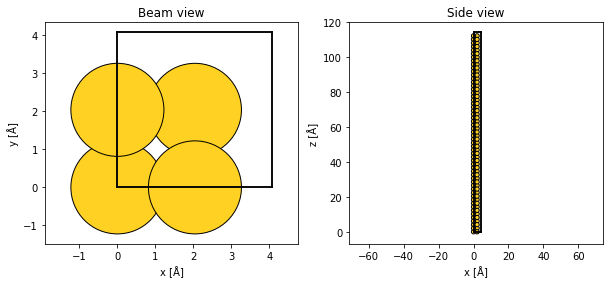

In [2]:
atoms = ase.build.bulk("Au", cubic=True) * (1, 1, 28)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
abtem.show_atoms(atoms, scale=0.9, ax=ax1, title="Beam view");
abtem.show_atoms(atoms, scale=0.9, ax=ax2, plane="xz", title="Side view");

In [3]:
potential = abtem.Potential(atoms, slice_thickness=1, sampling=0.05)

plane_wave = abtem.PlaneWave(energy=200e3)

We set up our calculation by calling the `multislice` method, producing an exit wave function.

In [4]:
exit_wave = plane_wave.multislice(potential)

As discussed previously, nothing is yet calculated. To execute the simulation we need to call `compute`. 

In [5]:
exit_wave.compute();

```{note}
Notice that we did not provide the sampling or extent of the wave function above, and so the wave function automatically adopted the grid of the potential. A `GridUndefinedError` will be thrown if the grid is not defined for both the wave function and potential.
```

We can then visualize the intensity of the resulting exit wave function.

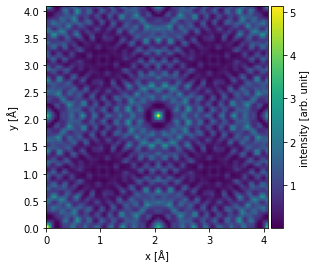

In [6]:
exit_wave.intensity().show(cbar=True);

In realistic HRTEM experiments, the wave functions have to be magnified by an objective lens which introduces aberrations and effectively cuts off large scattering angles. How this is handled will be discussed in our introduction to the [contrast transfer function](contrast_transfer_function.ipynb).

Here, we apply a defocus of $50 \ \mathrm{Å}$ and an aperture of $20 \ \mathrm{mrad}$.

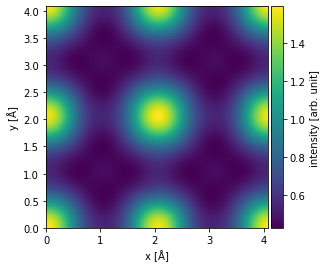

In [7]:
exit_wave.apply_ctf(defocus=-50, semiangle_cutoff=20).intensity().show(cbar=True);

### Electron diffraction patterns

Instead of an image, we can instead simulate a [selected area diffraction (SAD)](https://en.wikipedia.org/wiki/Selected_area_diffraction) experiment by using the `DiffractionPatterns` method. We use `block_direct=True` to block the direct beam: it typically has a much higher intensity than the scattered beams, and thus it is typically not possible to show it on the same scale.

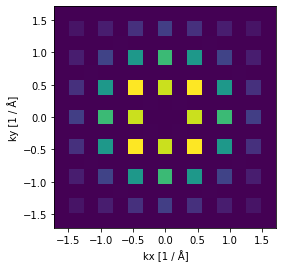

In [8]:
diffraction_patterns = exit_wave.diffraction_patterns(block_direct=True, max_angle=40)
diffraction_patterns.show();

You may wonder why do the diffraction spots look like squares. This is because the incoming wave function is a periodic and infinite plane wave, hence the diffraction spots are points with no size. However, since we are discretizing the wave function on a square grid (i.e. pixels), the spots can only be as small as single pixels. In real SAD experiments, the spot size is broadened due to the finite extent of the crystal as well instrumental effects.

We can use `index_diffraction_spots` to create a represent SAD patterns as a mapping of Miller indices to the intensity of the corresponding reflections. The cell size of the *conventional* unit cell have to be provided in order to index the pattern.

In [9]:
indexed_spots = diffraction_patterns.index_diffraction_spots(cell=4.08)
indexed_spots

`IndexedDiffractionPatterns` facilitates the creation of a visualization that corresponds closer with typical textbook illustrations overlaying the Miller indices of the non-equivalent diffraction spots. We see that the $(100)$ reflection is extinguished, as is expected for a FCC crystal in the $\left<100\right>$ zone axis.

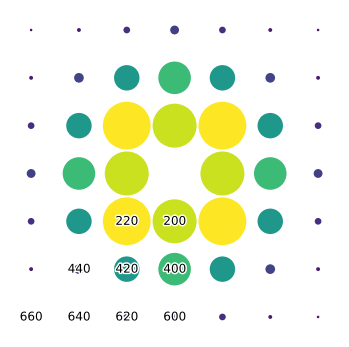

In [10]:
indexed_spots.remove_low_intensity(0.01).show();

It is also possible to obtain a table of the intensity values of the indexed diffraction spots. We have normalized their intensity to the most intense spot (not including the direct beam) and only spots with an intensity of at least $1 \ \%$ that are included (as determined by the `remove_low_intensity(0.01)` method above).

In [11]:
df = indexed_spots.to_dataframe(normalize=True)

df

,200,220,400,420,440,600,620,640,660
0,0.91946,1.0,0.680809,0.531901,0.202399,0.185042,0.139771,0.081426,0.053048


We observe that the $(220)$ spots have a higher intensity than the $(200)$ spots; this is due to dynamical scattering — which is accounted for by the multislice algorithm.

## Writing exit wave functions

You can write exit wave function directly to disk, which will also trigger the computation to run.

In [12]:
exit_wave = plane_wave.multislice(potential)

exit_wave.to_zarr("./data/exit_waves.zarr", overwrite=True);

We can read the wave function back in as shown below, and see that they are identical to the calculated exit wave.

In [13]:
imported_wave = abtem.from_zarr("./data/exit_waves.zarr")

assert imported_wave.compute() == exit_wave.compute()

## Thickness series

*ab*TEM easily allows us to obtain the wave function at intermediate steps of the multislice algorithm, thus allowing us to see how the wave function evolves as it passes through the potential. To create such a *thickness series* we set the `exit_planes` keyword of the *potential*. `exit_planes` may be given as a tuple of slice indices at which to return the wave function, or simply as a single integer to indicate the step between those slice indices.

Below we create a `Potential` as above, but we set `exit_planes=36`. When running the multislice simulation we obtain an *ensemble* of wave functions $\psi_n(\vec{r})$ with $n=0,36,72,\ldots$.

In [14]:
potential_series = abtem.Potential(
    atoms, slice_thickness=1, sampling=0.05, exit_planes=36
)

exit_wave_series = plane_wave.multislice(potential_series).compute()

exit_wave_series.shape

(5, 82, 82)

We show the wave function intensity as an exploded plot, enforcing a joint intensity color scale with a given maximum value.

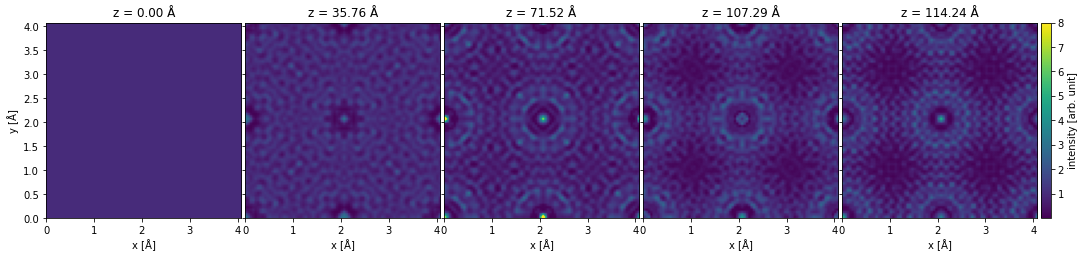

In [15]:
exit_wave_series.show(
    explode=True,
    figsize=(18, 5),
    common_color_scale=True,
    cbar=True,
    vmax=8,
    image_grid_kwargs={"axes_pad": 0.05},
);

We can naturally do the same with diffraction patterns.

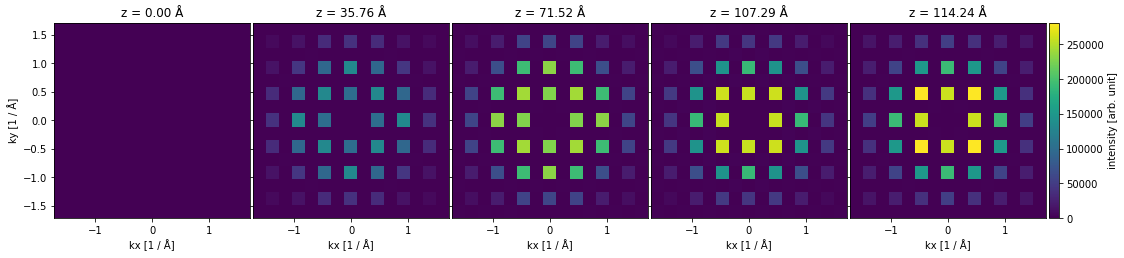

In [16]:
diffraction_patterns_series = exit_wave_series.diffraction_patterns(block_direct=True, max_angle=40)

diffraction_patterns_series.show(
    explode=True,
    figsize=(18, 5),
    common_color_scale=True,
    cbar=True,
    image_grid_kwargs={"axes_pad": 0.05},
);

In both cases, it is clear that the deeper through the speciment the probe beam propagates, the greater is its redistribution of intensity.

## Multislice simulation with a probe
Simulations of a focused electron probe differ only in minor details. We create our initial wave function as a convergent beam with an energy of $200 \ \mathrm{keV}$ (note the conversion from $\mathrm{keV}$ to the default units of $\mathrm{eV}$) and a convergence semiangle of $9 \ \mathrm{mrad}$.

In [17]:
probe = abtem.Probe(energy=100e3, semiangle_cutoff=9.)

There are two additional considerations to take into account when performing multislice simulations with probes: self-interaction errors and probe placement. 

### Self-interaction
Self-interaction errors happen when the probe overlaps with its periodic images. We see this happening below: the clearest visual clue is that the probe does not have a circular symmetry, even though we defined no non-symmetric aberrations. (Note that we need to define a grid for the probe to display it, which can be done manually above, or by matching it to the grid of the potential as below).

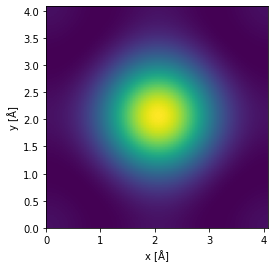

In [18]:
probe.grid.match(potential)

probe.build().show();

We get rid of self-interaction by increasing the extent of the potential until the probe intensity is sufficiently small at the boundary. Note that this should be true at any slice of the potential when running the multislice algorithm.

The potential may be extended by modifying the atoms, but for crystals we can also use the `CrystalPotential` we introduced earlier. Here we repeat the potential used above by $5$ times in and $x$ and $y$.

In [19]:
tiled_potential = abtem.CrystalPotential(potential, (5, 5, 1))

Now, when the probe is matched to the potential, there is no significant self-interaction.

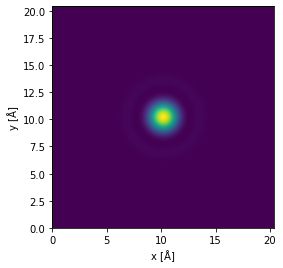

In [20]:
probe.grid.match(tiled_potential)
probe.show();

### Probe position

Above the probe was placed (by default) at the center of the potential. Later we will learn how to scan the probe for STEM simulations, but for our purposes here, we manually select a few positions.

We create an array of $5$ probe positions across the center of the potential (found by taking half of its full extent in both directions)

In [21]:
center = (tiled_potential.extent[0] / 2, tiled_potential.extent[1] / 2)

positions = center + np.array([np.linspace(-1.02, 1.02, 5), np.zeros(5)]).T

positions

array([[ 9.18, 10.2 ],
       [ 9.69, 10.2 ],
       [10.2 , 10.2 ],
       [10.71, 10.2 ],
       [11.22, 10.2 ]])

Running the multislice algorithm with a scan given by these probe positions, we obtain an ensemble of $5$ wave functions, one for each of the positions.

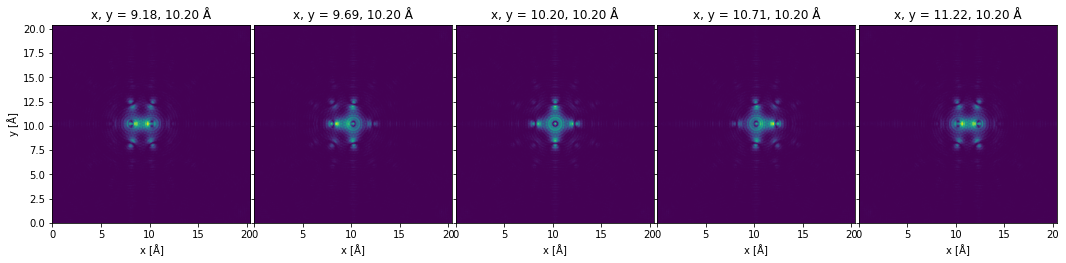

In [22]:
exit_wave_probe_positioned = probe.multislice(
    scan=positions, potential=tiled_potential
).compute()

exit_wave_probe_positioned.show(
    explode=True, figsize=(18, 5), image_grid_kwargs={"axes_pad": 0.05},
);

This is the first time we encounter a slightly longer calculation time: in fact, we are running five independent full multislice passes, one for each probe position, which takes more time.

### Convergent beam diffraction

A convergent beam (electron) diffraction (CBED) pattern may be calculated in the same manner as the SAD pattern. Here we select the third probe position by indexing the ensemble created above and calculate its diffraction pattern.

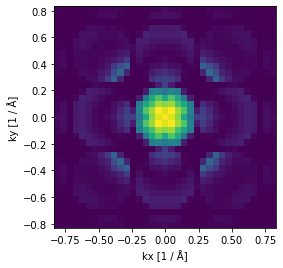

In [23]:
exit_wave_probe_positioned[2].diffraction_patterns(max_angle=30).show();

The diffraction pattern is rather pixelated due to our limited sampling. Improving reciprocal-space sampling is equivalent to tiling in real space. Below the potential is repeated by $10$ times in $x$ and $y$, thus improving the Fourier space sampling by a factor of $2$. We also set `exit_planes=36` to obtain a series of $5$ exit waves.

In [24]:
potential_extra_tiled = abtem.CrystalPotential(potential, (10, 10, 1), exit_planes=36)

exit_wave_extra_tiled = probe.multislice(potential_extra_tiled).compute()

The potential is now significantly larger, and thus the simulations again take a little time. We show the resulting series of diffraction patterns below.

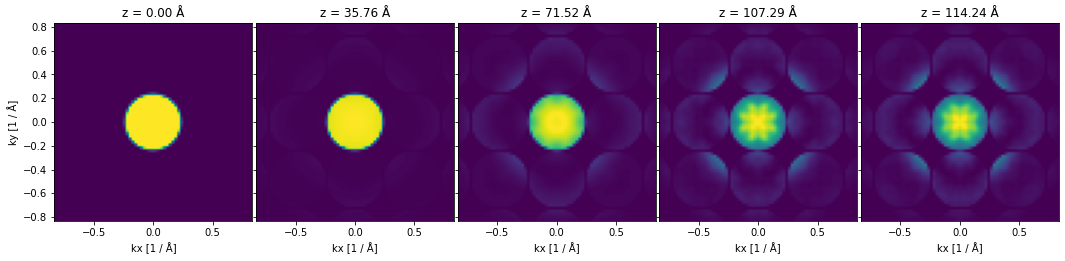

In [25]:
exit_wave_extra_tiled.diffraction_patterns(max_angle=30).show(
    explode=True, figsize=(18, 5), image_grid_kwargs={"axes_pad": 0.05},
);

## Small-angle beam tilt

Small amounts of beam tilt (or equivalently sample tilt) may be included by a small modification to the propagator function

$$
    P(\vec{k}) = \exp\left[-i \pi \lambda k^2 \Delta z + 2 \pi i \Delta z (k_x \tan\theta_x + k_y \tan\theta_y)\right] \quad ,
$$

where $\theta_x$, $\theta_y$ is the beam tilt in the $x$, $y$ directions. This is equivalent to shifting the wave function between slices and is only valid for very small tilts of no more than about $100 \ \mathrm{mrad}$.

```{seealso}
See our example on simulating precession electron diffraction experiments.
```

In *ab*TEM, beam tilt may be included using the `tilt` keyword of either `PlaneWave` and `Probe`. Below we create the same `Probe` used above with a series of $5$ tilts ranging from $0 \ \mathrm{mrad}$ to $9.2 \ \mathrm{mrad}$ along the $x$-axis using our built-in `distributions` module.

In [26]:
tilt_x = abtem.distributions.uniform(0, 9., 5)

probe_tilt = abtem.Probe(
    energy=100e3, semiangle_cutoff=9., defocus=0, tilt=(tilt_x, 0.0)
)
probe_tilt.grid.match(tiled_potential)

We set up the multislice algorithm with the tilted probes – the tilt is represented as an ensemble axis in the resulting exit waves – and then compute.

In [27]:
exit_wave_tilt = probe_tilt.multislice(
    potential=abtem.CrystalPotential(potential, (5, 5, 1))
)
exit_wave_tilt.compute()

We plot the tilt series as an exploded plot. We see that, for thick samples, even minor tilts can have a significant effect on the resulting CBED pattern.

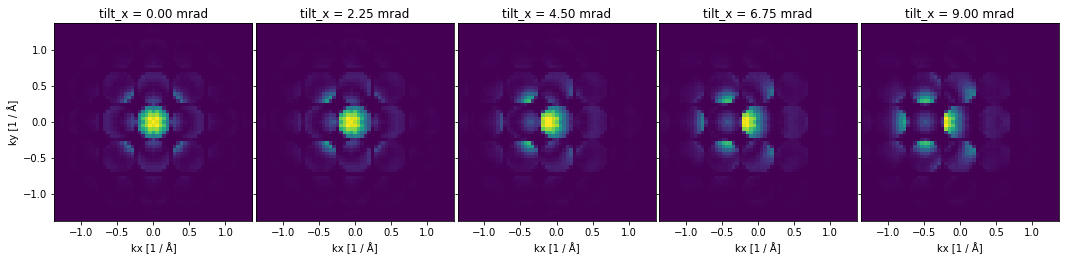

In [28]:
exit_wave_tilt.diffraction_patterns(max_angle=50).show(
    explode=True, figsize=(18, 5), image_grid_kwargs={"axes_pad": 0.05},
);

```{note}
Beam tilt can also have a strong interplay with the aberrations of the electron optics. See our introduction to the [contrast transfer function](contrast_transfer_function.ipynb) for details, which is where we turn next.
```